### Solution by: Henrique Voni

## Description
The challenge consists of forecasting the number of people that uses NYC metro using 7 years of history collected from turnstiles and stations. Most of the registries are audits that occurred every 4 hours, along with other entries (see `DESC` field description).


## TL;DR Proposed solution
The solution is proposed in two parts: the first one contains all data visualization and exploratory data analysis that guided me in the modelling part. I'd rather focus on the 4 busiest stations since (a priori) they don't share any relevant information with each other, and therefore it was generated one model per station.

### Modelling 
It worth mentioning that i don't like to plug any DNN and expect good results without understanding what the problem requires. So, i like to start with simple/classic models and then proceed adding complexity to the solution. In this case, i used ARIMA models with a good analysis on parameter discovery and an ETS model (Exponential Smoothing). In a more depth analysis, i'd apply deep networks and/or Transformers that can capture long term temporal correlations in data.

### Handling with data
Performance was a big part of this challenge. Some memory optimizations were made in order to work with the dataset, but `pandas` is not the best choice around for dealing with this amount of data. On a real case with appropriate time, i'd explore `dask` or `polars` for a better suitable solution.

Please consider that this notebook requires ~10Gb RAM.


## Dataset Field Description

- CA = Control Area (A002) 
- UNIT = Remote Unit for a station (R051) 
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00) 
- STATION = Represents the station name the device is located at 
- LINENAME = Represents all train lines that can be boarded at this station Normally lines are represented by one character. LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains. 
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND
- TIME = Represents the datetime value for the registry
- DESC = Represent the REGULAR scheduled audit event (Normally occurs every 4 hours) 
    1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
    2. Additionally, there may be a RECOVR AUD entry This refers to a missed audit that was recovered. 
- ENTRIES = The comulative entry register value for a device 
- EXIST = The cumulative exit register value for a device


### If you have any questions or issues running the experiment, i'd be more than happy to help at voni.henrique@gmail.com

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error as MSE
from scipy.signal import detrend

import utils

sns.set_theme()

In [3]:
INPUT_PATH = 'drive/MyDrive/mta-dataset'

columns = ['time', 'station', 'desc', 'entries', 'exits']
column_dtypes = {
    'station' : 'string',
    'desc' : 'string', 
    'entries' : 'Int32',
    'exits' : 'Int32'
}

df = pd.concat([pd.read_csv(file, 
                             dtype=column_dtypes, 
                             usecols=columns, 
                             parse_dates=['time']) 
                 for file 
                 in glob(f'{INPUT_PATH}/*.csv')])

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79609191 entries, 0 to 7466024
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   time     datetime64[ns]
 1   station  string        
 2   desc     string        
 3   entries  Int32         
 4   exits    Int32         
dtypes: Int32(2), datetime64[ns](1), string(2)
memory usage: 11.7 GB


In [4]:
df = utils.downcast_columns(df)

In [5]:
df.desc.value_counts()

REGULAR       72112005
RECOVR AUD     1295363
DOOR OPEN      1148262
DOOR            848822
RECOVR          814449
OPEN            765653
AUD             758985
DOOR CLOSE      549129
LOGON           326688
TS              246098
VLT             236770
LGF-MAN         200242
OPN             167170
TS VLT OPN      138962
BRD                246
CHG                205
TS BRD CHG         132
LGF-SHUTDN           2
037                  2
101                  1
069                  1
064                  1
9798999A9B           1
B5B6B7B8B9           1
REGUL                1
Name: desc, dtype: Int64

In [6]:
df = df[df.desc == "REGULAR"]
df = df.drop('desc', axis=1)
df.shape

(72112005, 4)

In [7]:
df.head()

,time,station,entries,exits
0,2010-04-17 04:00:00,LEXINGTON AVE,2704717,928793
1,2010-04-17 04:00:00,LEXINGTON AVE,2697632,566683
2,2010-04-17 04:00:00,LEXINGTON AVE,1127722,3943492
3,2010-04-17 04:00:00,LEXINGTON AVE,2425570,3733289
4,2010-04-17 04:00:00,LEXINGTON AVE,2214633,3021589


In [8]:
by_station = df.groupby(['station', 'time'], as_index=False).agg({'entries': 'sum', 'exits':'sum'}).convert_dtypes()
del df

# Feature cleaning and processing

It was noticed that `entries` and `exits` strangely appears to have negative values. Since these negative registries are quantitatively similar to the regular values, it was assumed that it is a typo and the absolute value was considered.

Also, there were registries with null values, meaning that a turnstile could be deffective or inoperant for a moment. I decided not to treat these isolated cases with interpolation because the sum of all turnstiles of a station would still be normal.

I created new variables: `traffic, weekday, hour`. The first one will be the target variable, since it sums all entries and exits. Doing some online research, it was found that NYC subway stations have integration with other mobility services, and also provides a pathway for citizens. This explains why some registries have more `exits` than `entries`, for instance.

In [9]:
by_station[['entries','exits']] = by_station[['entries','exits']].apply(lambda x: abs(x))
by_station['traffic'] = by_station['entries'] + by_station['exits']
by_station['weekday'] = by_station['time'].dt.day_name()
by_station['hour'] = by_station['time'].dt.hour

In [10]:
by_station.traffic.sort_values(ascending=False)

1539775     13770494777
1539772     13770466649
1539770     13770459709
1539768     13770457839
1539766     13770449702
               ...     
4764526               0
3939716               0
10185827              0
9907690               0
4738474               0
Name: traffic, Length: 10900432, dtype: Int64

# Data Distribution

The plot below shows that most of traffic registries (~98%) have values below 2 billion. Therefore, it is assumed that values are consistent.

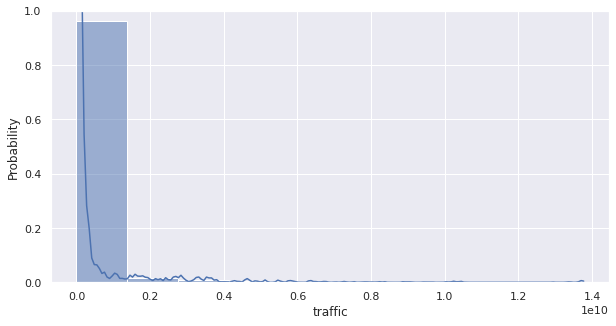

In [11]:
plt.figure(figsize=(10,5))
plt.ylim(0,1)
sns.histplot(by_station.traffic, bins=10, kde=True, stat='probability')

In [12]:
by_station[by_station.traffic > 1e10 * 0.2].shape[0]

299518

In [13]:
by_station[by_station.traffic <= 1e10 * 0.2]

,station,time,entries,exits,traffic,weekday,hour
14,1 AV,2015-12-28 13:42:12,441296212,434327340,875623552,Monday,13
181,1 AV,2016-01-25 08:00:00,441618012,434532976,876150988,Monday,8
189,1 AV,2016-01-26 13:22:05,441635257,434542251,876177508,Tuesday,13
333,1 AV,2016-02-19 13:27:24,441946821,434729204,876676025,Friday,13
373,1 AV,2016-02-25 12:48:23,442020087,434778842,876798929,Thursday,12
...,...,...,...,...,...,...,...
10900427,ZEREGA AVE,2015-12-25 09:00:00,53459763,452862,53912625,Friday,9
10900428,ZEREGA AVE,2015-12-25 13:00:00,53459875,452912,53912787,Friday,13
10900429,ZEREGA AVE,2015-12-25 17:00:00,53460012,453003,53913015,Friday,17
10900430,ZEREGA AVE,2015-12-25 21:00:00,53460233,453171,53913404,Friday,21


In [14]:
by_station[by_station.traffic > 1e10 * 0.2].shape[0] / by_station.shape[0]

0.02747762657479997

In [15]:
helper_a = by_station.set_index('time')
helper_a

,station,entries,exits,traffic,weekday,hour
time,,,,,,
2015-12-26 08:00:00,1 AV,1407672247,1469227704,2876899951,Saturday,8
2015-12-26 12:00:00,1 AV,1407672381,1469228103,2876900484,Saturday,12
2015-12-26 16:00:00,1 AV,1407673613,1469229805,2876903418,Saturday,16
2015-12-26 20:00:00,1 AV,1407675983,1469232401,2876908384,Saturday,20
2015-12-27 00:00:00,1 AV,1407679021,1469236238,2876915259,Sunday,0
...,...,...,...,...,...,...
2015-12-25 09:00:00,ZEREGA AVE,53459763,452862,53912625,Friday,9
2015-12-25 13:00:00,ZEREGA AVE,53459875,452912,53912787,Friday,13
2015-12-25 17:00:00,ZEREGA AVE,53460012,453003,53913015,Friday,17


In [16]:
traffic_by_station = by_station.groupby('station').sum().traffic

In [17]:
traffic_by_station.sort_values(ascending=False).head(50)

station
23 ST              64308539835622
125 ST             61096228488196
CHAMBERS ST        59974195853722
FULTON ST          58206792661636
CANAL ST           56148230261067
42 ST-PORT AUTH    54580650950943
34 ST-HERALD SQ    48876029243820
86 ST              43755645023371
72 ST              41252792137387
TIMES SQ-42 ST     39711926894409
57 ST-7 AV         39469938243012
34 ST-PENN STA     38732409805843
104 ST             38670221598487
42 ST-PA BUS TE    37282788076644
BROOKLYN BRIDGE    30091359839033
14 ST              28668740371691
183 ST             28520855548625
57 ST-7 AVE        27948565496072
170 ST             27501507751433
42 ST-TIMES SQ     27297859784446
59 ST-COLUMBUS     26514385171901
28 ST              25951688280912
59 ST COLUMBUS     24893830737316
CORTLANDT ST       24100872048605
42 ST-BRYANT PK    24076438723285
BOWLING GREEN      23574917006822
145 ST             21809836524912
CHRISTOPHER ST     21372243720044
59 ST              21044169182085
116 ST

In [18]:
traffic_by_station.nlargest(4).index.values

array(['23 ST', '125 ST', 'CHAMBERS ST', 'FULTON ST'], dtype=object)

In [19]:
# filter top 4 stations with most traffic
top_4_stations = traffic_by_station.nlargest(4).index.values
helper_a = helper_a[helper_a.station.isin(top_4_stations)]

In [20]:
grouped_a = helper_a.groupby(['station', 'weekday'], as_index=False).sum()

## Visualizing weekdays

The plot belows shows that business days represents the majority of volume/traffic. Curiously, the 2nd and 3rd busiest stations (25ST, CHAMBERS ST) present "more constant" values, with little gain in business days.

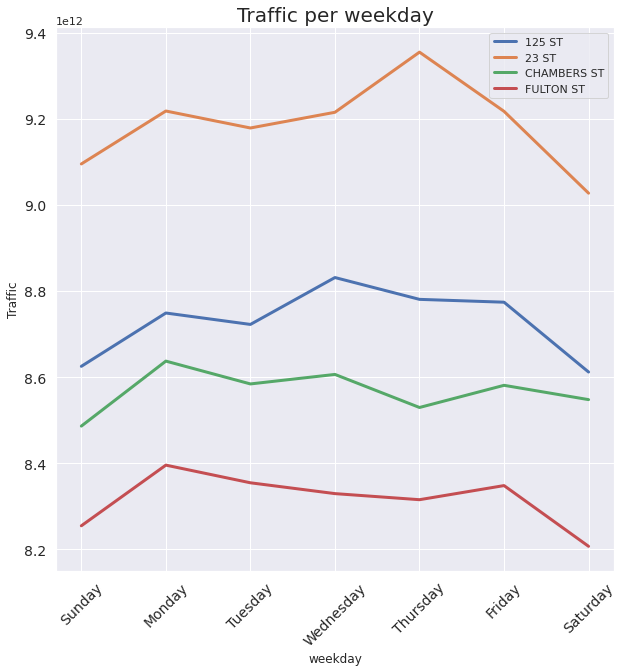

In [21]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
stations = grouped_a.station.unique()
plt.figure(figsize=(10,10))
for station in stations:
    ax = grouped_a[grouped_a.station == station].set_index('weekday').reindex(days).traffic.plot(linewidth=3, fontsize=14, rot=45, ylabel='Traffic', grid=True)    
ax.legend(labels=stations, loc='best', bbox_to_anchor=(1,1))
plt.title('Traffic per weekday', fontsize=20)
plt.show()

## Visualizing Monthly data

Sampling data in a monthly basis can help us detect some aspects such as trends, seasons, and other stuff that could be difficult to check in smaller different scales.

From the plot below, we can verify different traffic rates during the year. However, a better analysis involves decomposing the series.

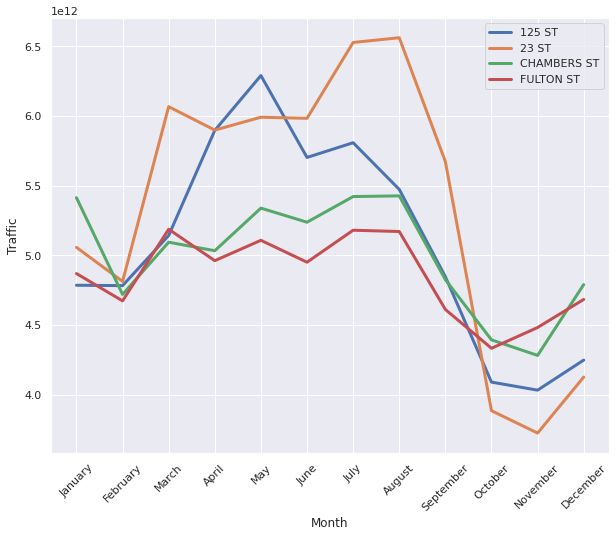

In [22]:
months = ['January', 'February', 'March',
          'April', 'May', 'June', 
          'July', 'August', 'September', 
          'October', 'November', 'December']


monthly = helper_a.groupby('station').resample('M').sum()


fig, ax = plt.subplots(figsize=(10,8))

for station, new_df in monthly.groupby(level=0, as_index=False):
    x = list(range(1,13))
    new_df = new_df.reset_index()
    new_df['month_n'] = new_df.time.dt.month
    volume_m = new_df.groupby('month_n').sum()
    fig_axis = volume_m.plot(y='traffic', rot=45, ax=ax, linewidth=3, xlabel='Month', ylabel='Traffic')
    fig_axis.set_xticks(x)
    fig_axis.set_xticklabels(months)


ax.legend(stations)
plt.show()

## Decomposition analysis

A time series can be decomposed in its base value, residuals, trend and seasonality. Decomposition comes handy when treating stationarity, detrending and other preprocessing techniques. Also, it can provide a good direction on model and parameter selection (such as ARIMA, which we will be using later).


We can see from the plots below that there's a clear trend in February with a drop in July-August. It is important to assert that our model will capture this behaviour during the forecasting task. 

Decomposition for 125 ST series


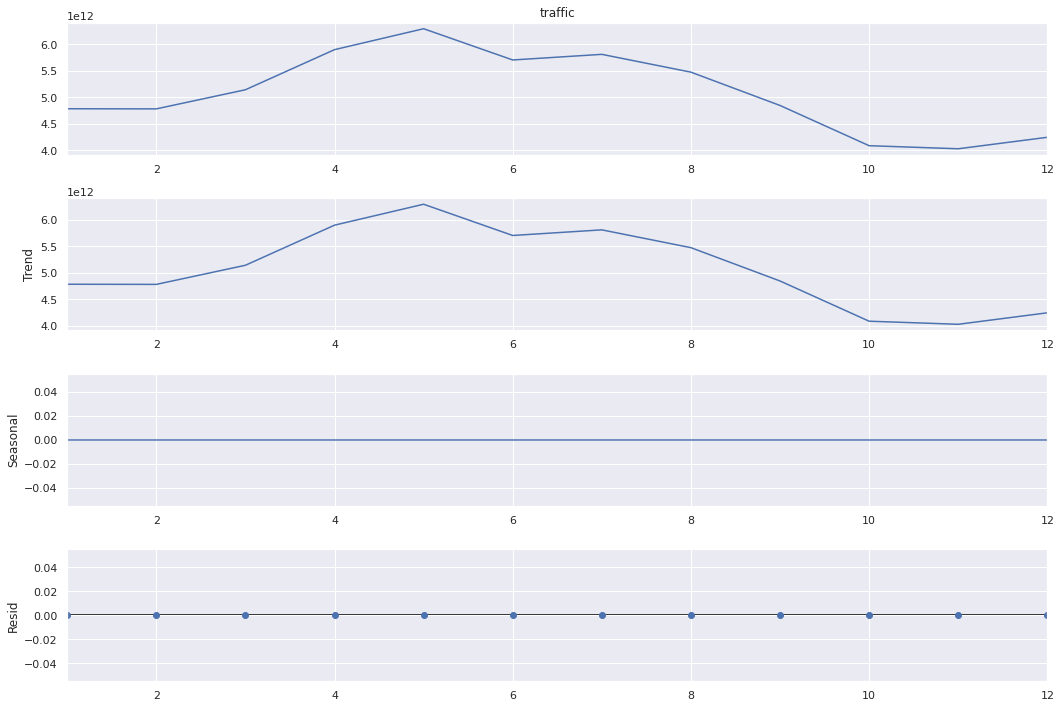

Decomposition for 23 ST series


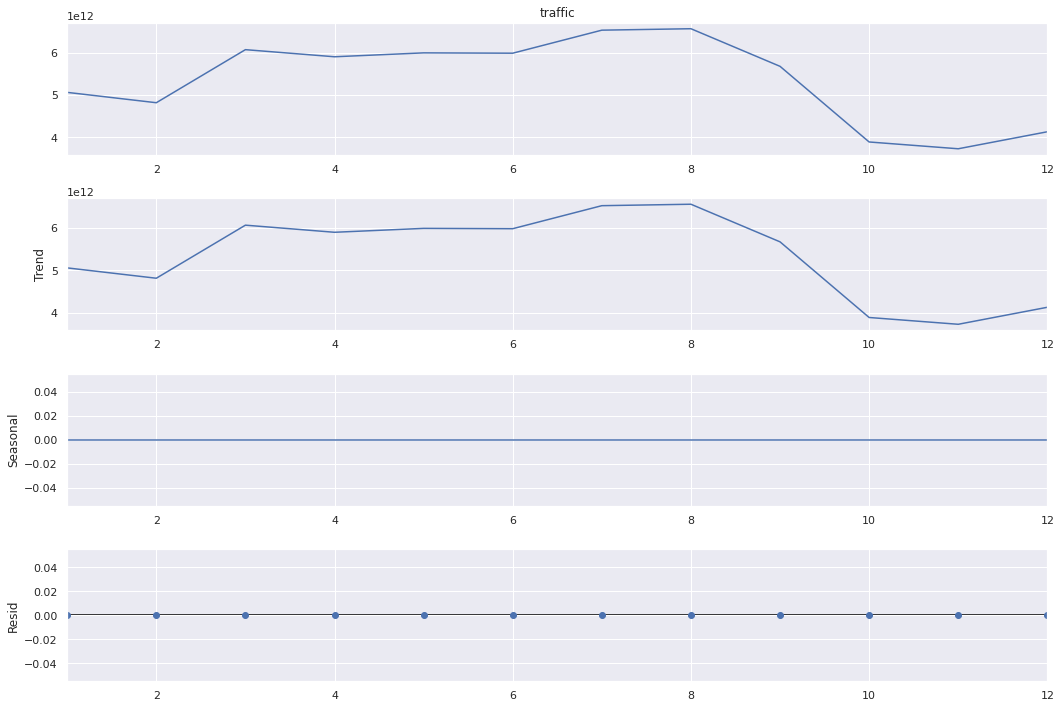

Decomposition for CHAMBERS ST series


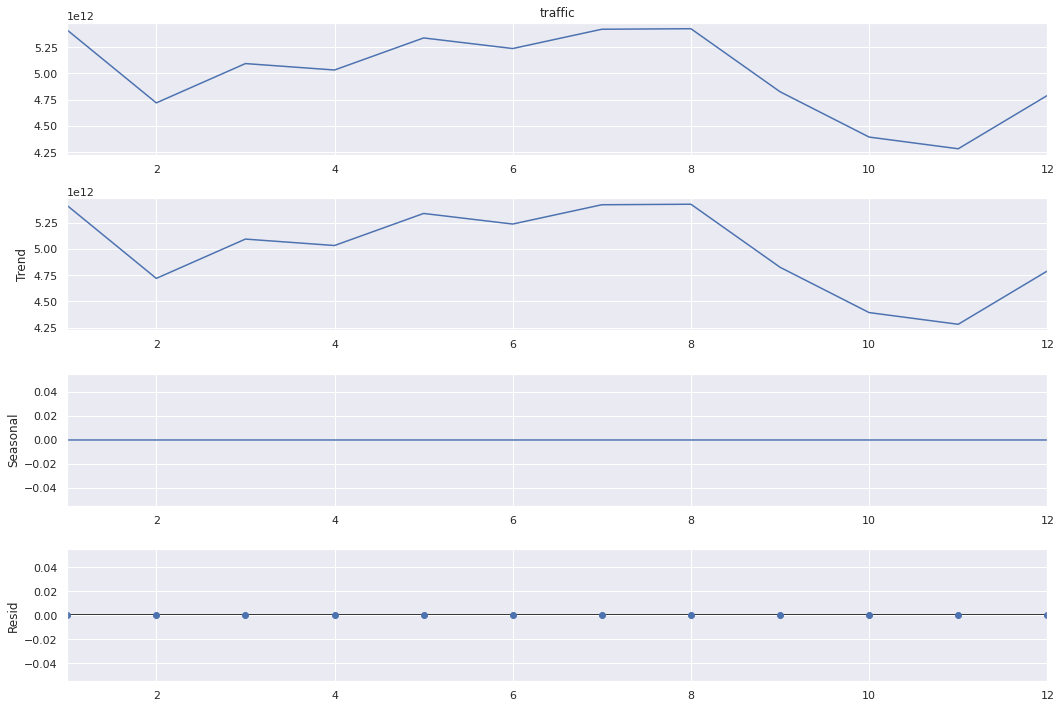

Decomposition for FULTON ST series


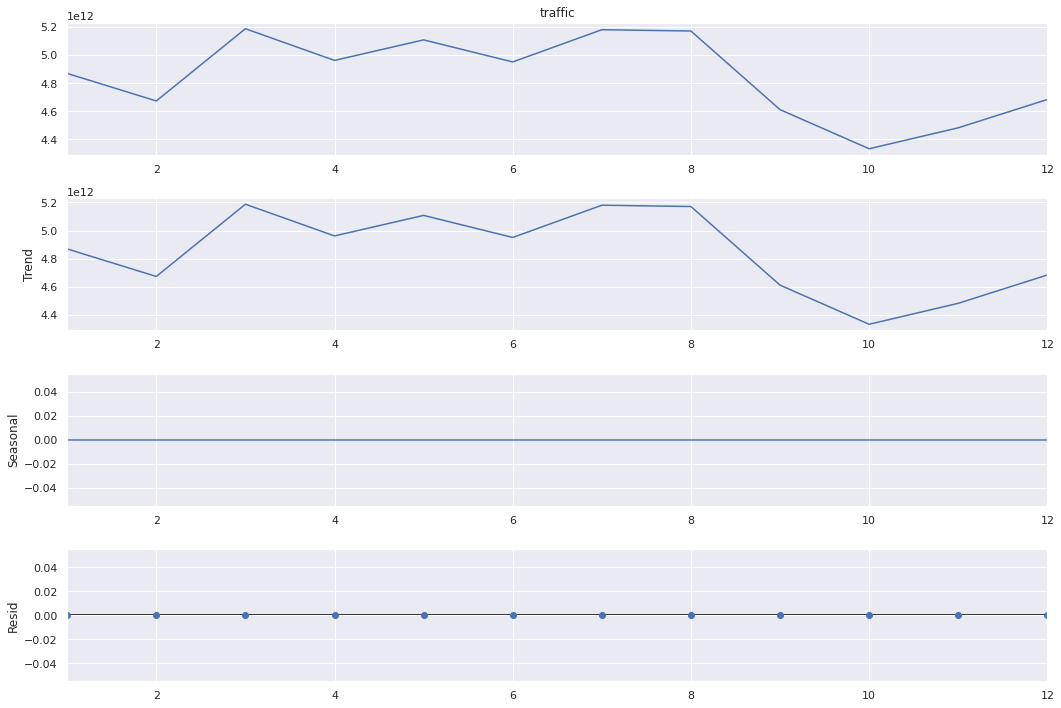

In [23]:
for station, new_df in monthly.groupby(level=0, as_index=False):
    print(f'Decomposition for {station} series')
    x = list(range(0,12))
    new_df = new_df.reset_index()
    new_df['month_n'] = new_df.time.dt.month
    volume_m = new_df.groupby('month_n').sum()
    
    plt.rcParams.update({'figure.figsize': (15,10)})
    decompose_df = volume_m.reset_index().set_index('month_n')
    result_mul = seasonal_decompose(decompose_df['traffic'], 
                                    model='additive', 
                                    period=1, 
                                    extrapolate_trend='freq')
    result_mul.plot()
    plt.show()    

(24,)
(24,)
(24,)
(24,)


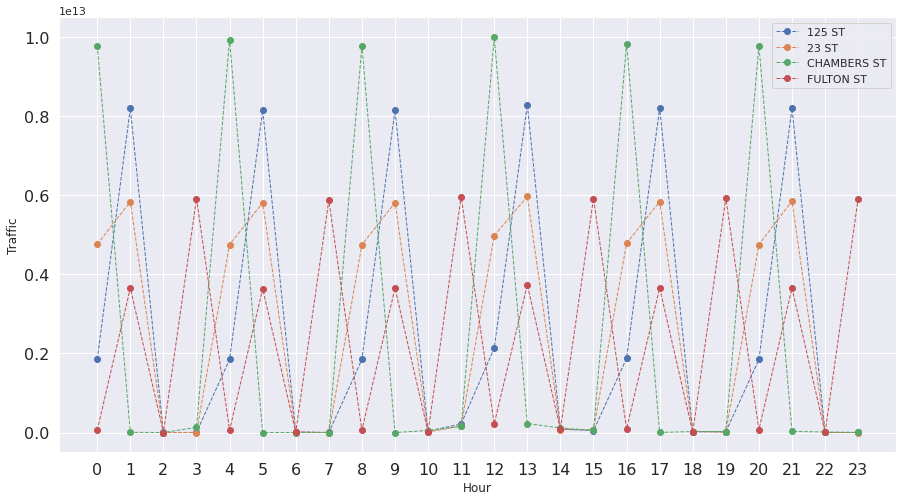

In [24]:
hours = list(range(24))

hourly = helper_a.groupby(['station']).resample('H').sum().reset_index()
time = hourly.time
hourly = hourly.groupby(['station', time.dt.hour]).sum()

fig, ax = plt.subplots(figsize=(15,8))
for station, new_df in hourly.groupby(level=0, as_index=False):
    print(new_df.traffic.shape)
    fig_axis = new_df.plot(y='traffic', ax=ax, linewidth=1, linestyle='--', marker='o', xlabel='Hour', ylabel='Traffic', fontsize=16)
    fig_axis.set_xticks(hours)
    fig_axis.set_xticklabels(hours)
    
ax.legend(stations)
plt.show()

There's a curious repetitive pattern along the hours. Highest values are found during business hours, which indicates people going/returning to/from work.

In [25]:
by_station.describe()

,entries,exits,traffic,hour
count,1.090043e+07,1.090043e+07,1.090043e+07,1.090043e+07
mean,1.071164e+08,8.540730e+07,1.925237e+08,1.093495e+01
std,4.688426e+08,4.107054e+08,8.586735e+08,6.880540e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.766820e+05,1.411170e+05,4.119600e+05,5.000000e+00
50%,9.218486e+06,5.922686e+06,1.637459e+07,1.200000e+01
75%,3.135720e+07,2.132267e+07,5.533542e+07,1.700000e+01
max,7.531719e+09,7.245311e+09,1.377049e+10,2.300000e+01


In [26]:
daily = helper_a.groupby('station').resample('D').sum()
daily

del by_station

In [27]:
daily.describe()

,entries,exits,traffic,hour
count,1.086800e+04,1.086800e+04,1.086800e+04,10868.000000
mean,1.232918e+10,1.008394e+10,2.241312e+10,139.465863
std,1.427324e+10,1.216373e+10,2.595925e+10,62.591646
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,9.861091e+08,8.005748e+08,1.795799e+09,111.000000
50%,5.176921e+09,1.903381e+09,7.094163e+09,126.000000
75%,2.396549e+10,2.352357e+10,4.737314e+10,204.000000
max,1.165355e+11,1.017673e+11,2.183028e+11,650.000000


# Autocorrelation plot

Autocorrelation plot shows that temporal correlation between the series and its lags are higher for lower lags/most recent previous values.

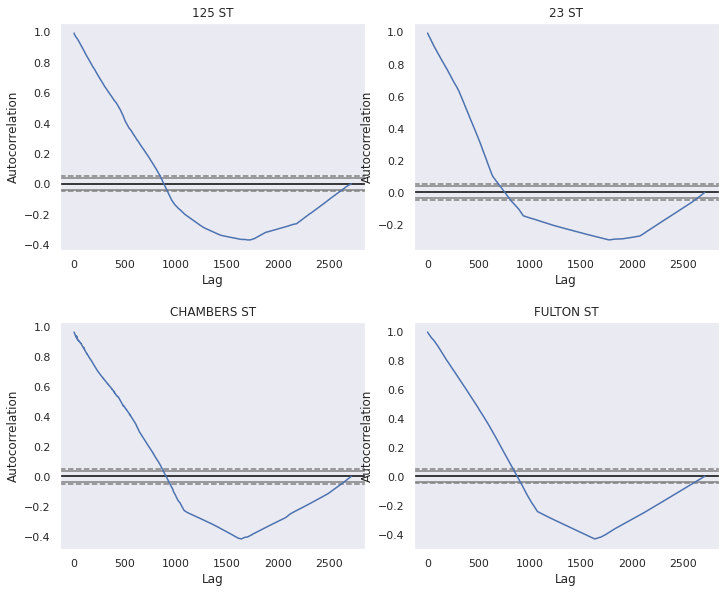

In [28]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

fig.tight_layout(h_pad=4)

for ax, (station, new_df) in zip(axs.flatten(), daily.groupby(level=0, as_index=False)):
    pd.plotting.autocorrelation_plot(new_df.traffic.tolist(), ax=ax)
    ax.set_title(station)
plt.show()

In [29]:
top_4_stations

array(['23 ST', '125 ST', 'CHAMBERS ST', 'FULTON ST'], dtype=object)

# Modelling: forecasting 2017 data

In order to generate a model that can capture temporal patterns, i used 2010-2016 for model training and 2017 traffic as evaluation.

Personally, i like to start simple. There's no need to plug a fancy DNN and expect good results if simpler models are good options. In light of this, i proposed the usage of ARIMA and Exponential Smoothing methods. 

For ARIMA, i made a basic analysis that could guide the choice of `[p, d, q]` parameters. For `d`, i applied `Adfuller`'s hypothesis test to check stationarity. `p` and `q` were analyzed with autocorrelation and partial correlation plots. Lag values superior to the threshold area should perform better. In a real case scenario with adequate computational power, hyperparameter selection techniques such as `Grid Search` / `Random Search` could be applied.

I decided to create a model for each station, since i didn't make any correlation analysis among stations and/or used exogenous variables in training.

As evaluation criteria, i'm using: 

- Root Mean Squared Error (RMSE), that sums residuals and keep error in the same scale of input data.

- Mean Absolute Percentage Error (MAPE), which is the proportion of the average absolute residuals. Since data is consisent enough (i.e. free of null values and rare extreme values), this metric can be helpful.

# Predicting 23 ST series

ADF Statistic: 0.377172
p-value: 0.980621


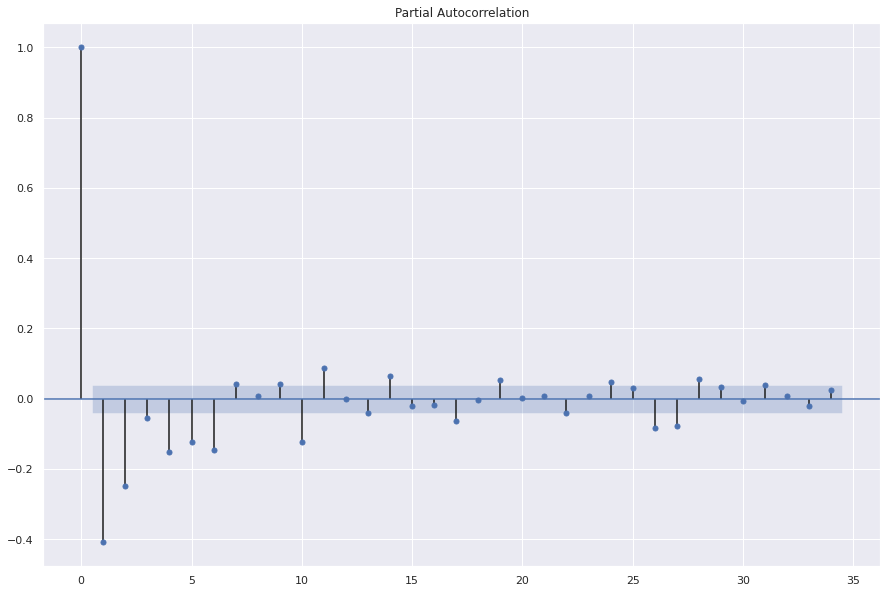

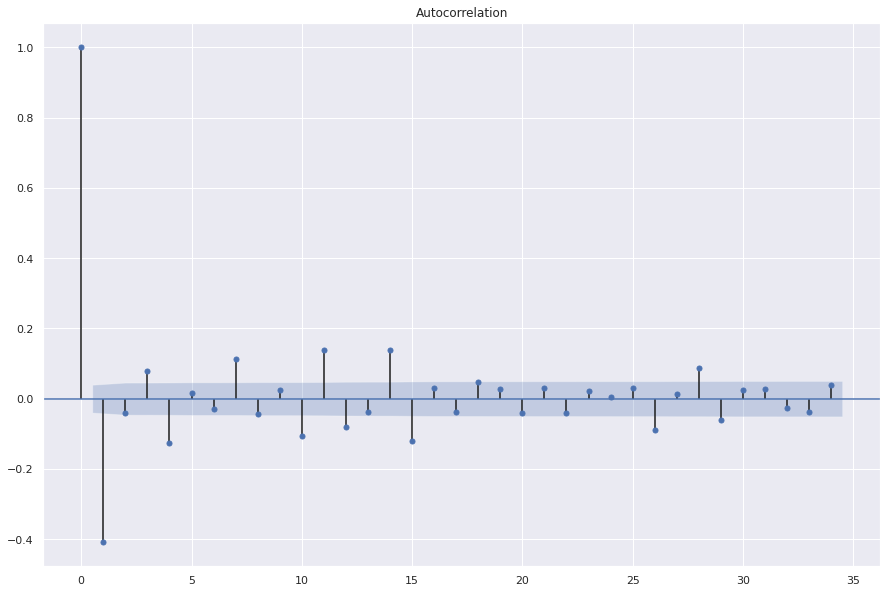

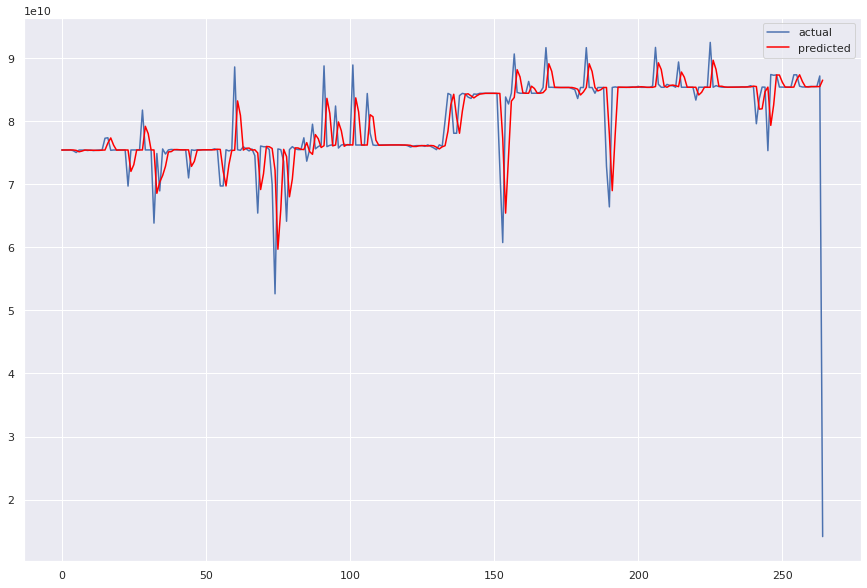

RMSE ARIMA: 6125746478.402329
MAPE ARIMA: 4.76042511472714


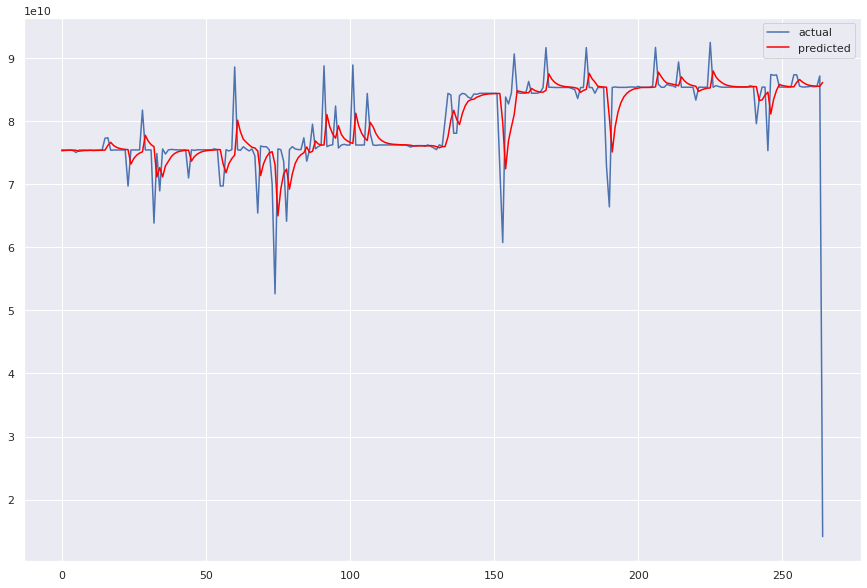

RMSE ETS: 5865576128.258383
MAPE ETS: 4.628156854930676


In [30]:
import warnings
warnings.filterwarnings("ignore")

x_train, x_test = utils.generate_train_test(df=daily, station_name='23 ST', test_date_start='2017-01-01')
utils.analyze_arima_params(x_train)

history, predictions = utils.model_pipeline(model_name='ARIMA', x_train=x_train, x_test=x_test, p=1, d=1, q=0)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ARIMA: {rmse}')
print(f'MAPE ARIMA: {mape}')


history, predictions = utils.model_pipeline(model_name='ETS', x_train=x_train, x_test=x_test)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ETS: {rmse}')
print(f'MAPE ETS: {mape}')

# Predicting 125 ST series

ADF Statistic: -0.643870
p-value: 0.860758


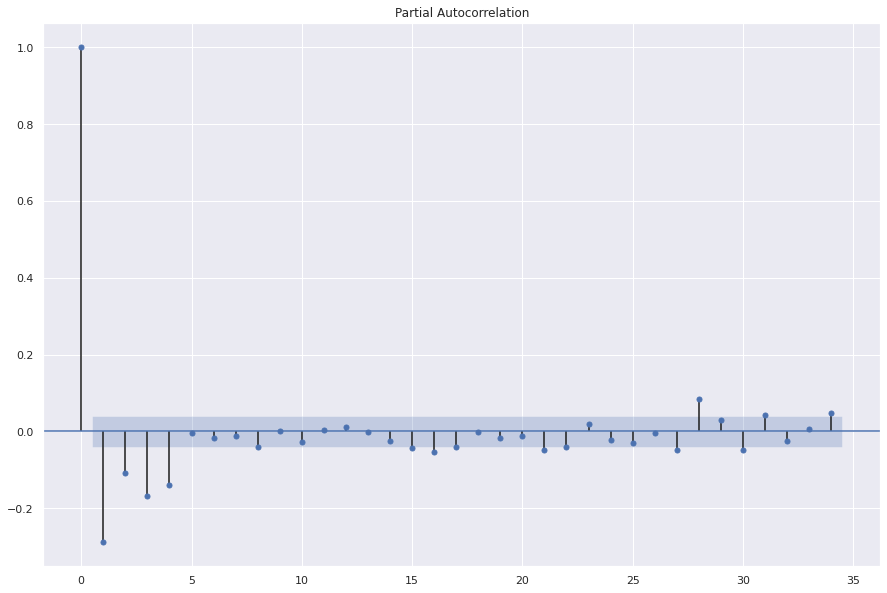

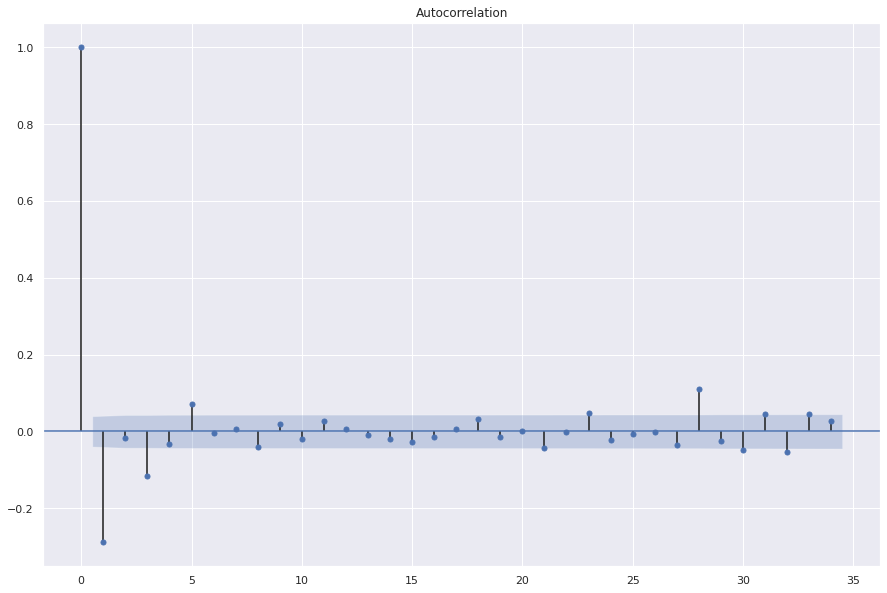

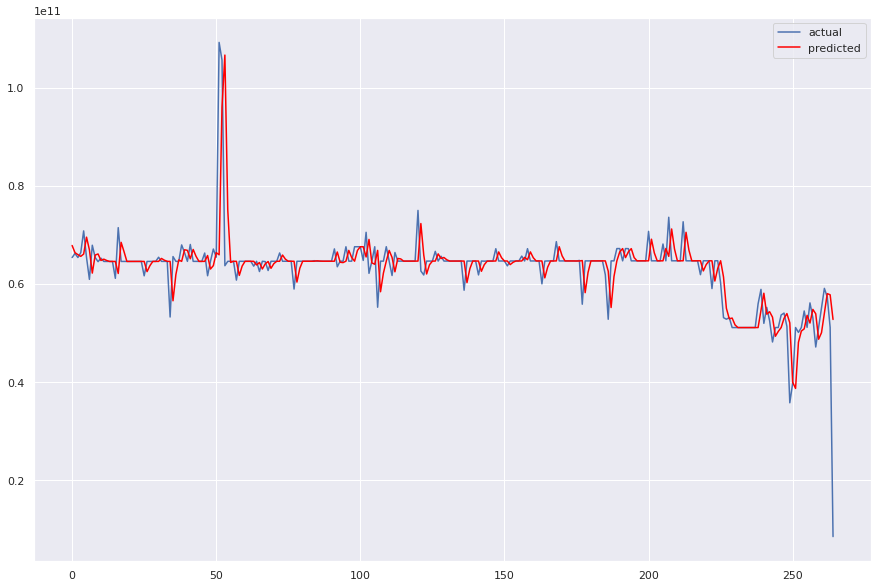

RMSE ARIMA: 5756167547.80089
MAPE ARIMA: 5.7621325291886105


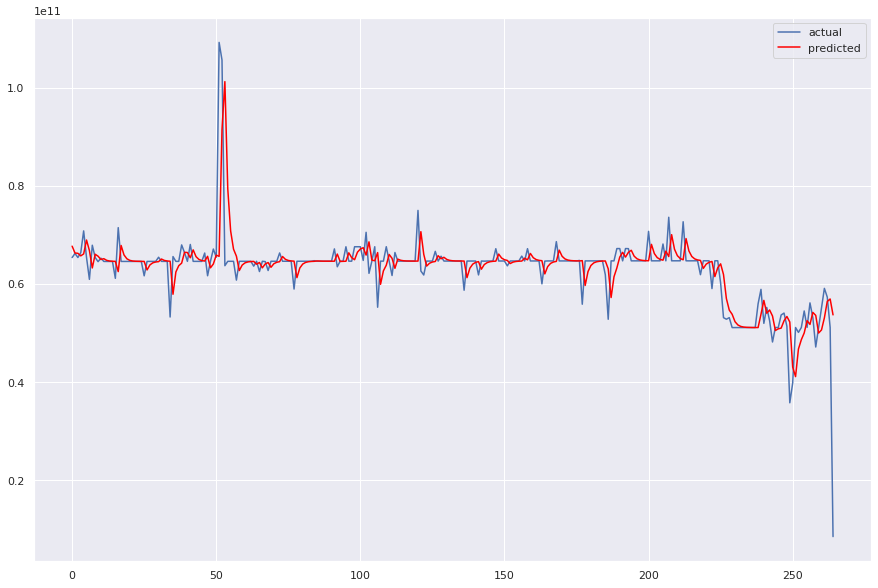

RMSE ETS: 5643139416.386289
MAPE ETS: 5.8021812002317805


In [31]:
x_train, x_test = utils.generate_train_test(df=daily, station_name='125 ST', test_date_start='2017-01-01')
utils.analyze_arima_params(x_train)

history, predictions = utils.model_pipeline(model_name='ARIMA', x_train=x_train, x_test=x_test, p=1, d=1, q=0)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ARIMA: {rmse}')
print(f'MAPE ARIMA: {mape}')


history, predictions = utils.model_pipeline(model_name='ETS', x_train=x_train, x_test=x_test)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ETS: {rmse}')
print(f'MAPE ETS: {mape}')

# Predicting CHAMBERS ST series

ADF Statistic: -0.663107
p-value: 0.856076


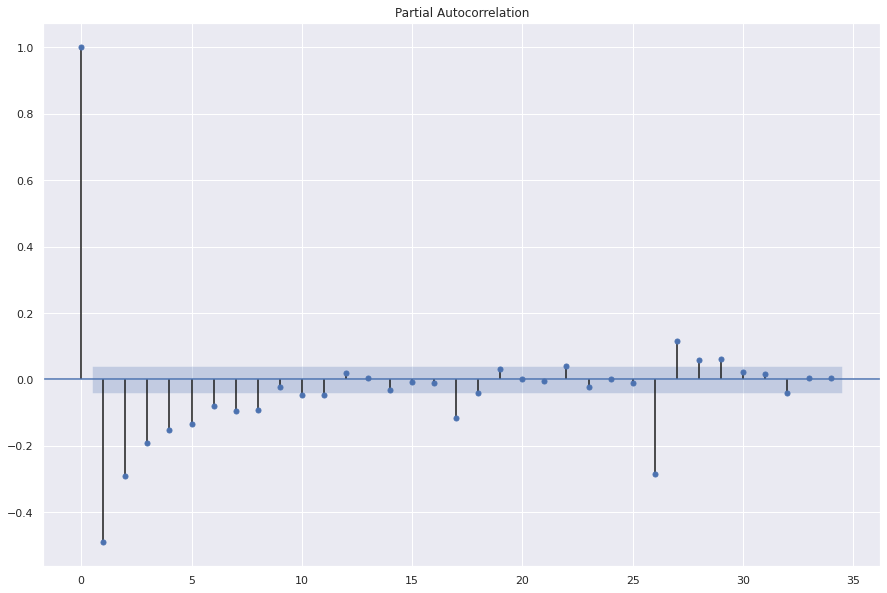

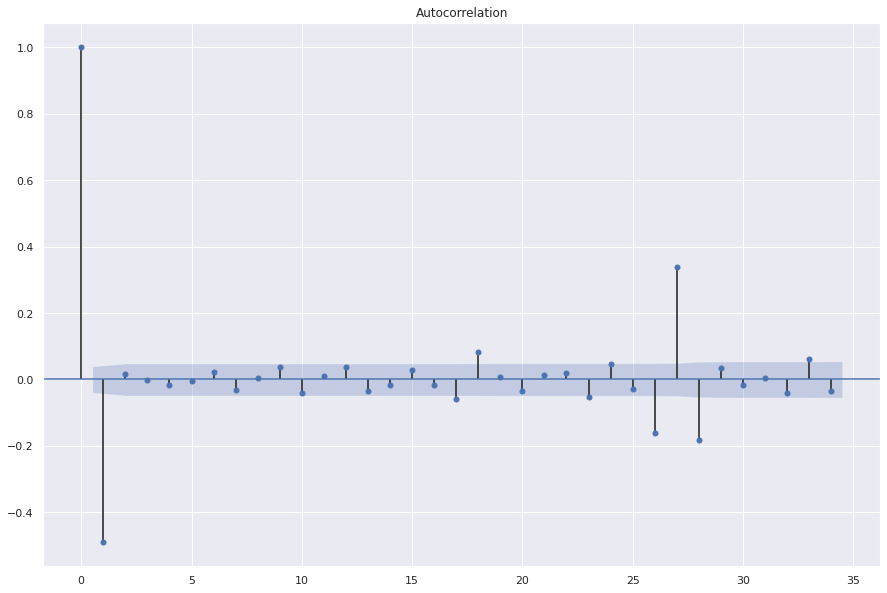

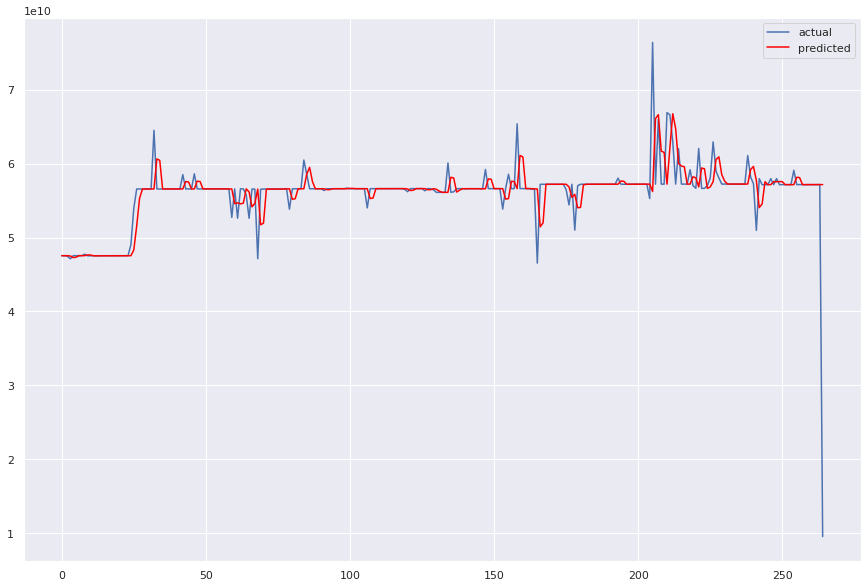

RMSE ARIMA: 3871928241.3069115
MAPE ARIMA: 3.8964390807749347


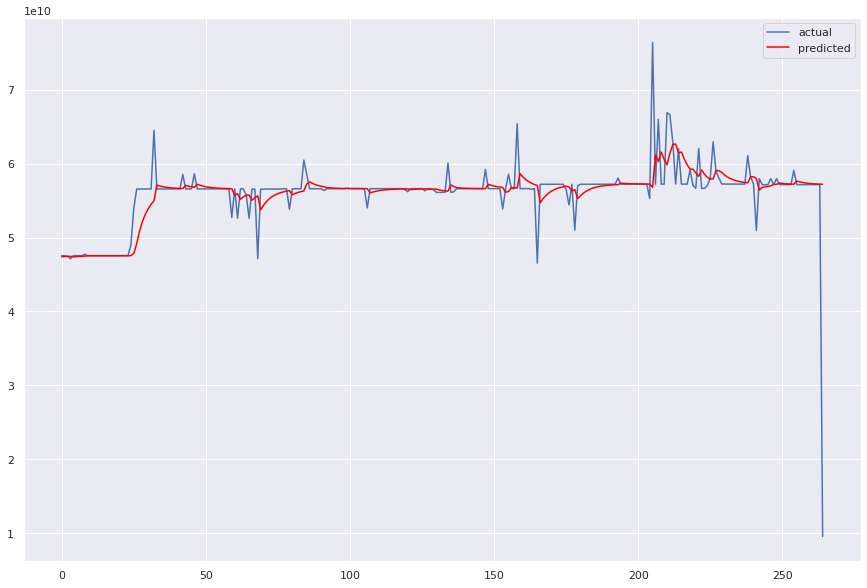

RMSE ETS: 3768535307.1178
MAPE ETS: 3.8473053274478253


In [32]:
x_train, x_test = utils.generate_train_test(df=daily, station_name='CHAMBERS ST', test_date_start='2017-01-01')
utils.analyze_arima_params(x_train)

history, predictions = utils.model_pipeline(model_name='ARIMA', x_train=x_train, x_test=x_test, p=1, d=1, q=0)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ARIMA: {rmse}')
print(f'MAPE ARIMA: {mape}')


history, predictions = utils.model_pipeline(model_name='ETS', x_train=x_train, x_test=x_test)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ETS: {rmse}')
print(f'MAPE ETS: {mape}')

# Predicting FULTON ST series

ADF Statistic: -0.385971
p-value: 0.912415


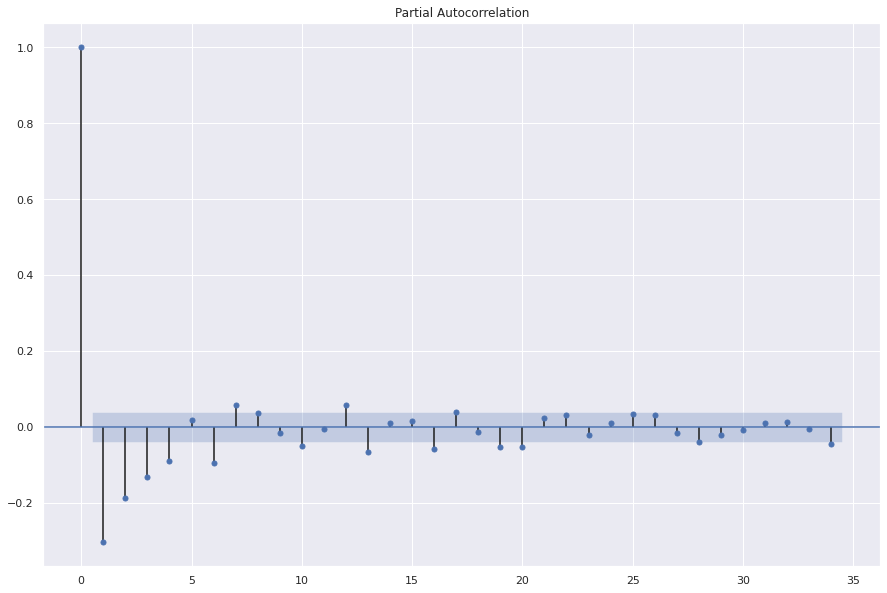

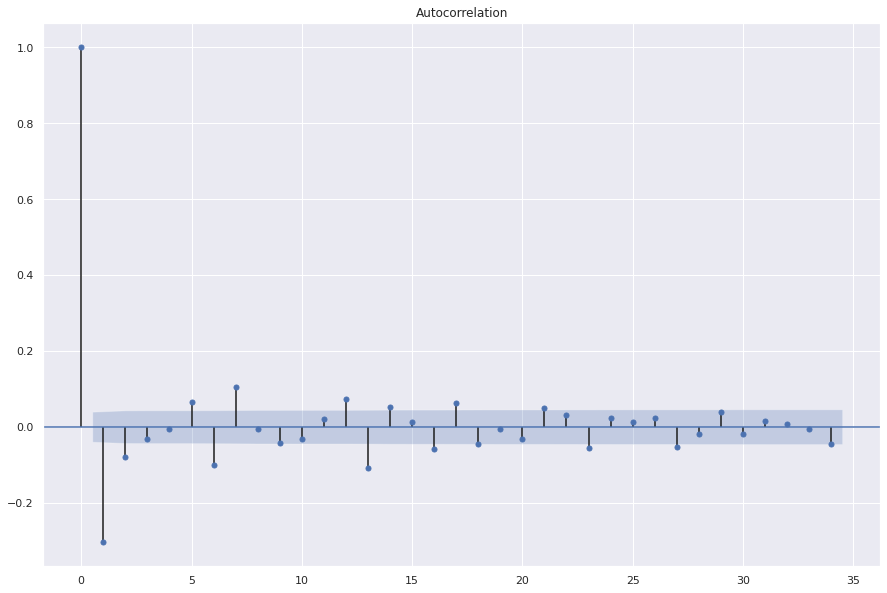

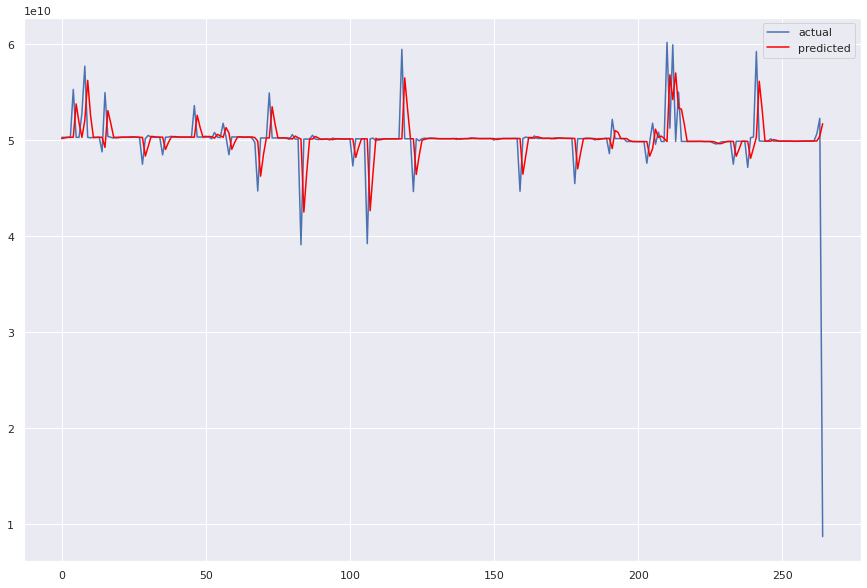

RMSE ARIMA: 3485819300.3738947
MAPE ARIMA: 3.933418363965452


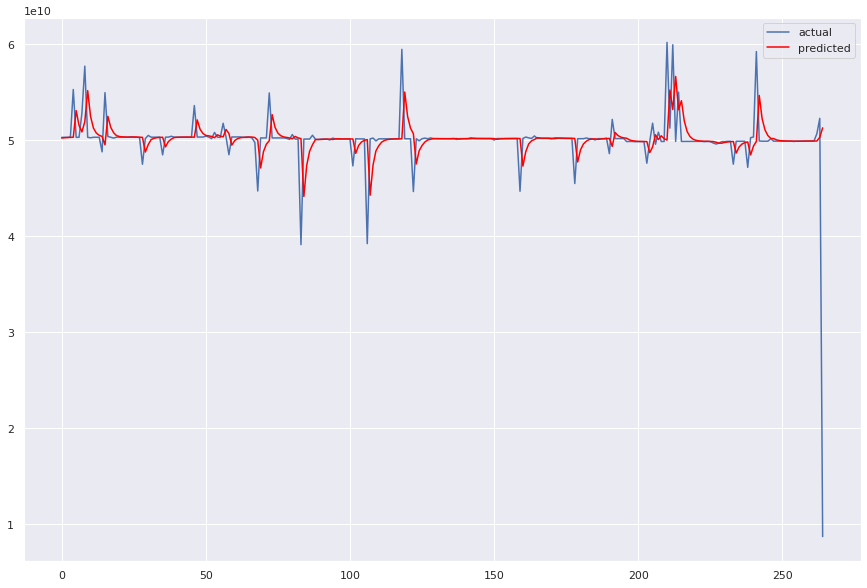

RMSE ETS: 3388036449.7257004
MAPE ETS: 3.8609523320500876


In [33]:
x_train, x_test = utils.generate_train_test(df=daily, station_name='FULTON ST', test_date_start='2017-01-01')
utils.analyze_arima_params(x_train)

history, predictions = utils.model_pipeline(model_name='ARIMA', x_train=x_train, x_test=x_test, p=1, d=1, q=0)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ARIMA: {rmse}')
print(f'MAPE ARIMA: {mape}')

history, predictions = utils.model_pipeline(model_name='ETS', x_train=x_train, x_test=x_test)

plt.plot(x_test)
plt.plot(predictions, color='red')
plt.legend(['actual', 'predicted'])
plt.show()


rmse = np.sqrt(MSE(x_test, predictions))
mape = utils.MAPE(x_test, predictions)
print(f'RMSE ETS: {rmse}')
print(f'MAPE ETS: {mape}')

# Model Insights

We can see clearly for every case that ARIMA models performed better on forecasting the series when compared to a simple smoothing method because it could identify patterns/trends better, despite of exponential smoothing generating lower RMSE and MAPE metrics. Regarding ARIMA parameters, we can conclude that:

- Adfuller hypothesis test shows that a p-value higher than 0.05 indicates the non-stationarity of the series in all cases. For sake of simplicity, i started setting ARIMA `d` parameter = `1` and got a good result. A further analysis should explore differencing techniques in order to make series stationary.

- Partial Autocorrelation and Autocorrelation plots shows highest values at `0`, which means no correlation with lag values. However, good results were achieved with `p` and `q` parameters equal to 1;

Also, further investigation should consider the offset in predicted values.

# Insight summary and further work

- MTA data has temporal nuances regarding traffic such as seasonality and trend in different sampling periods. 
- Weekend days are the less busiest days in stations;
- Hourly sampling showed higher traffic in business hours, mostly caused by people going/returning to/from work.
- Data indicates less usage of metro service in July-August and December-January. One possible cause is that July-August marks a vacation period (start of Summer) and December-January drop is related to Holidays.
- ARIMA models could provide a decent forecasting using short lag periods (as indicated in autocorrelation analysis).;
- Simpler models (ETS) couldn't converge and performed poorly on data.
- Data is non-stationary and requires detrending;
- Some registries pointed null values. Interpolation techniques should be applied in deeper investigations.
- With proper feature engineering and data processing procedures, machine learning algorithms such as LightGBM and ensembles could provide better results. I'd also consider an analysis with this algorithms.